# RandomAgent Environment

In [1]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from copy import deepcopy
import numpy as np

class RandomAgentEnv(gym.Env):
    
    def __init__(self,rows = 8 , cols = 8, num_agents = 4):
        self.rows = rows
        self.cols = cols
        self.num_agents = num_agents
        
        self.start()
        self.action_space = spaces.Discrete(4)
        self.observation_space = self.observation()

    def observation(self):
        dist_list = []
        dist_list.append(np.abs(self.rows - 1 - self.ai_pos[0])+np.abs(self.cols - 1 - self.ai_pos[1]))
        for ag_pos in self.agent_pos:
            dist_list.append((np.abs(ag_pos[0] - self.ai_pos[0])+np.abs(ag_pos[1] - self.ai_pos[1])))
        # another state definition:return state.reshape(-1,self.rows,self.cols)
        # return distance for each random agent and goals + position of all agents(this is helpful for calculate Q_values)         
        return np.array(dist_list),(self.ai_pos,self.agent_pos)
    
    def load_env(self,ai_pos,agent_pos):
        self.ai_pos = ai_pos
        self.agent_pos = agent_pos
        self.render_box()
        
            
    def render_box(self):
        self.box = np.zeros((self.rows,self.cols))
        self.box[self.rows-1,self.cols-1] = 1/8
        self.box[self.ai_pos[0],self.ai_pos[1]] = 1
        for ag in self.agent_pos:
            self.box[ag[0],ag[1]] = 2
        return self.box

    
    def start(self):
        self.ai_pos = np.array([0,0])
        self.agent_pos = np.random.randint(2,self.rows-2,size=(self.num_agents,2))
        self.render_box()

    # move function:(handle up,right,left and down and return new position)    
    def move(self,pos,action):
        if action == 0: #right
            new_pos = np.array([pos[0],min(pos[1]+1,self.rows-1)])
        elif action == 1: #down
            new_pos = np.array([min(pos[0]+1,self.cols-1),pos[1]])
        elif action == 2: #left
            new_pos = np.array([pos[0],max(pos[1]-1,0)])
        elif action == 3: #up
            new_pos = np.array([max(pos[0]-1,0),pos[1]])
        else:
            raise Exception("Invalid action.")
        return new_pos

    def step(self, action):
        
        # Random Agents Move Handler
        new_agent_pos = self.agent_pos.copy()
        # random_agent_move = np.random.randint(0,4,size=self.num_agents)
        # random movement just in rows:right and left         
        random_agent_move = np.random.choice([0,2],size=self.num_agents)
        for index,(ag,agent_action) in enumerate(zip(self.agent_pos,random_agent_move)):
            new_ag = self.move(ag,agent_action)
            new_agent_pos[index] = new_ag            
        self.agent_pos = new_agent_pos.copy()
        
        # AI Move Handler
        new_ai_pos = self.ai_pos.copy()
        new_ai_pos = self.move(new_ai_pos,action)
        self.ai_pos = new_ai_pos
        
        # Render Box
        self.render_box()

        # Handle reward         
        reward = -1
        is_terminal = False
        # Check Collision With Random Agents         
        for ag in self.agent_pos:
            if ((self.ai_pos[0]==ag[0]) and (self.ai_pos[1]==ag[1])):
                reward = -50.0
                
        # Check if ai arrived at goal or not
        if ((self.ai_pos[0]==self.rows-1) and (self.ai_pos[1]==self.cols-1)):
            is_terminal = True
        return self.observation(), reward, is_terminal, {}

    def reset(self):
        self.start()
        return self.observation()

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Check Environment

In [2]:
env = RandomAgentEnv()
state,state_helper = env.reset()

In [3]:
# first number in array is the distance between ai and goal
# and from the second number till the end , numbers are the distance between ai and other random agent
print("state :%s"%state)

state :[14  6  4 10  6]


In [4]:
# position of ai and other random agent
state_helper

(array([0, 0]), array([[2, 4],
        [2, 2],
        [5, 5],
        [2, 4]]))

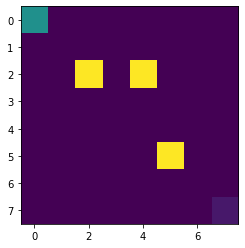

In [6]:
from matplotlib import pyplot as plt
plt.imshow(env.render_box(), interpolation='nearest')
plt.show()

# Custom Q_function , Not Deep

### Q_function,Parameterized
- *we parameterized Q_function just with 3 params,check it below*

$Q_{\theta}(dist_{AI},dist_{agent_{i}}) = \theta _{1}*dist_{AI} + \sum _{i} (e ^{\theta_{2} + \theta_{3}*dist_{agent_{i}}})$

- *we are trying to learn $\theta _{1},\theta_{2},\theta_{3}$ with q_learning (or minimizing td loss) methods also for stabilize learning process,we use experience replay*

- *The initial point for $\theta$ is [0,0,0],plus we use torch tensor with cuda enabled ,for calculate gradient in gpu* 

In [7]:
# theta initial point
import torch
theta = torch.Tensor([0,0,0]).cuda().requires_grad_() 

# value_function and Q_function

In [8]:
def value_function(state,theta):
    value = theta[0]*state[0]
    for s in state[1:]:
        value -= torch.exp(theta[1]+theta[2]*s)
    return value

In [9]:
value = value_function(state,theta)
value

tensor(-4., device='cuda:0', grad_fn=<SubBackward0>)

In [10]:
def Q_function(state_helper,theta):
    ns = []
    q_values = []
    for a in range(env.action_space.n):
        cop_env = RandomAgentEnv()
        cop_env.load_env(state_helper[0],state_helper[1])
        next_state_zip,_,_,_ = cop_env.step(a)
        next_state = next_state_zip[0]
        ns.append(next_state)
        q_values.append(value_function(next_state,theta))
    return q_values

In [11]:
q_values = Q_function(state_helper,theta)
q_values

[tensor(-4., device='cuda:0', grad_fn=<SubBackward0>),
 tensor(-4., device='cuda:0', grad_fn=<SubBackward0>),
 tensor(-4., device='cuda:0', grad_fn=<SubBackward0>),
 tensor(-4., device='cuda:0', grad_fn=<SubBackward0>)]

# e_greedy action selection

In [12]:
import math, random
def act(state_helper, theta,epsilon):
    if random.random() > epsilon:
        q_values = Q_function(state_helper,theta)
        action  = torch.argmax(torch.Tensor(q_values)).item()
    else:
        action = random.randrange(env.action_space.n)
    return action

# Exprience Replay

In [13]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state,state_helper, action, reward, next_state,next_state_helper, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state,state_helper, action, reward, next_state,next_state_helper, done))
    
    def sample(self, batch_size):
        state,state_helper, action, reward, next_state,next_state_helper, done = zip(*random.sample(self.buffer, batch_size))
        return state,state_helper, action, reward, next_state,next_state_helper, done
    
    def __len__(self):
        return len(self.buffer)

# TD_Loss

In [14]:
def compute_td_loss(batch_size,theta):
    state,state_helper ,action, reward, next_state,next_state_helper, done = replay_buffer.sample(batch_size)

    l = []
    for s,sh,a,r,ns,nsh,d in zip(state,state_helper, action, reward, next_state,next_state_helper, done):
        q_values = Q_function(sh,theta)
        next_q_values = Q_function(nsh,theta)
        q_next_max = torch.Tensor(next_q_values).max().item()
        l.append((r+gamma*q_next_max*(1-d)-q_values[a])**2)
    loss = torch.mean(torch.stack(l, dim=0))
    return loss

# Useful Plot func

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
def plot(frame_idx, rewards, losses, thetas):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(151)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(152)
    plt.title('loss')
    plt.plot(losses)
    
    if len(thetas) > 0:
        plt.subplot(153)
        plt.title('theta0')
        plt.plot(np.vstack(all_thetas)[:,0])
        plt.subplot(154)
        plt.title('theta1,theta2')
        plt.plot(np.vstack(all_thetas)[:,1])
        plt.plot(np.vstack(all_thetas)[:,2])
    plt.show()

# epsilon decay func

In [16]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

# Training Loop

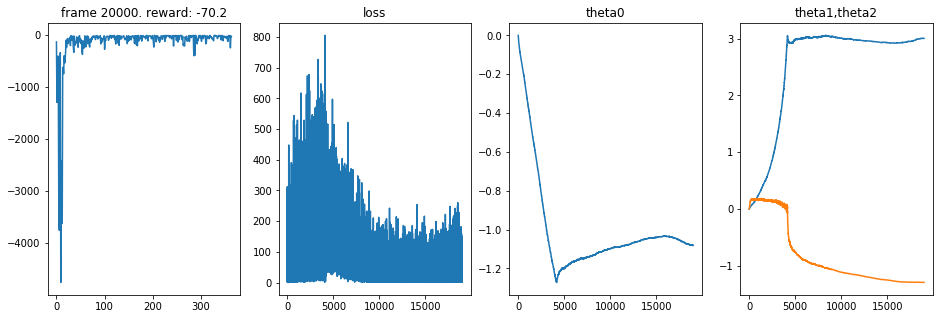

In [17]:
# num_frames = 50000
num_frames = 20000
batch_size = 32
gamma      = 0.99
lr = 0.00001

all_thetas = []
losses = []
all_rewards = []
all_values = []
episode_reward = 0
replay_buffer = ReplayBuffer(5000)
state,state_helper = env.reset()
theta = torch.Tensor([0,0,0]).cuda().requires_grad_() 

for frame_idx in range(0, num_frames + 1):
    
    epsilon = epsilon_by_frame(frame_idx)
    action = act(state_helper, theta , epsilon)
    
    next_state_zip, reward, done, _ = env.step(action)
    next_state = next_state_zip[0]
    next_state_helper = next_state_zip[1]
    replay_buffer.push(state,state_helper, action, reward, next_state,next_state_helper, done)
    
    state = next_state
    state_helper = next_state_helper
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > 1000:
        all_thetas.append(theta.cpu().detach().numpy())
        loss = compute_td_loss(batch_size,theta)
        loss.backward()
        theta = theta - lr*theta.grad
        theta = torch.Tensor(theta.cpu().data).cuda().requires_grad_()
        losses.append(loss.data.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, losses,all_thetas)

# Simulation And See What Happens!

In [18]:
# trained theta
theta

tensor([-1.0806,  3.0053, -1.2920], device='cuda:0', requires_grad=True)

In [19]:
def simulation(theta):
    all_state = []
    boxes = []
    is_terminal = True
    state,sh = env.reset()
    episode_reward = 0
    while is_terminal:
        boxes.append(env.render_box())
        all_state.append(sh)
        action = act(sh, theta , 0.05)
        next_state_zip, reward, done, _ = env.step(action)
        
    
        sh = next_state_zip[1]
        episode_reward += reward
    
        if done:
            is_terminal = False
    return episode_reward,boxes,all_state

In [20]:
t_episode_reward,boxes,all_states = simulation(theta)

In [21]:
len(boxes)
print(t_episode_reward)

-32


# Create gif

In [22]:
import scipy.misc
import cv2
import numpy as np
print(t_episode_reward)
for i,s in enumerate(boxes):
    res = cv2.resize(s, dsize=(128, 128), interpolation=cv2.INTER_AREA)
    # add your folders to save step by step frames of simulation     
    scipy.misc.toimage(res, cmin=0.0, cmax=2.0).save('pics/%s.png'%i)

-32


/home/migmig/anaconda3/envs/rl-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  
